In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [41]:
df = pd.read_csv("../data/uber_merged_52316.csv", parse_dates=['record_time'])

In [42]:
df.set_index('record_time', inplace=True)

In [43]:
df2 = df[['avg_price_est','display_name','city']].query("city == 'sf' and display_name == 'uberX'")[['avg_price_est']].copy()

In [97]:
hr = df2.ix['2016-03-01':].resample('H').mean()
hr.head()

,avg_price_est
record_time,
2016-03-01 00:00:00,35.289474
2016-03-01 01:00:00,43.146552
2016-03-01 02:00:00,47.929825
2016-03-01 03:00:00,40.275862
2016-03-01 04:00:00,34.175439


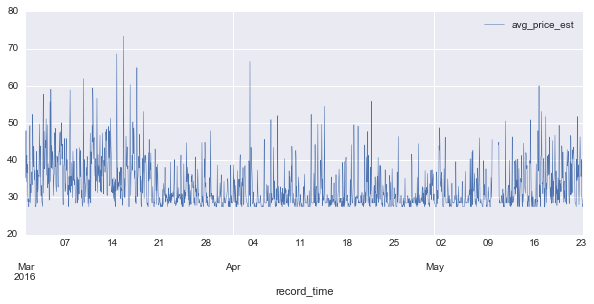

In [98]:
hr.plot(figsize=(10,4), lw=.5);

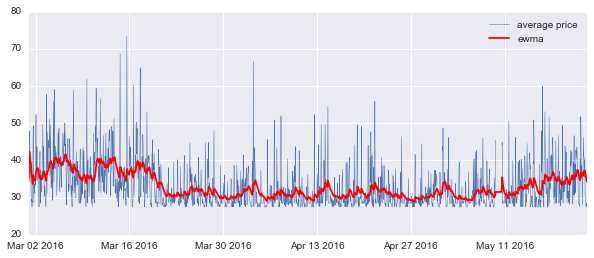

In [99]:
ewma = pd.DataFrame(hr['avg_price_est'].ewm(halflife=12).mean())
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(hr.index, hr['avg_price_est'].values, '-', label='average price', lw=.5)
ax.plot(ewma.index, ewma['avg_price_est'].values, '-', color='r', label='ewma')
ax.legend(loc='best');

In [104]:
hr['dayofweek'] = hr.index.dayofweek

(20.0, 80.0)

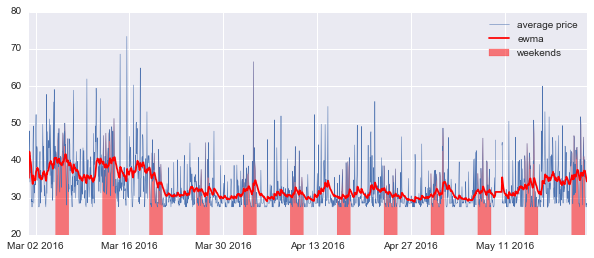

In [101]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(hr.index, hr['avg_price_est'].values, '-', label='average price', lw=.5)
ax.plot(ewma.index, ewma['avg_price_est'].values, '-', color='r', label='ewma')
ymin, ymax = ax.get_ylim()
ax.fill_between(hr.index, hr['avg_price_est'].values, where=hr['dayofweek'] > 4, alpha=0.5, label='weekends', color='r')
ax.legend(loc='best');
ax.set_ylim(ymin,ymax)

In [103]:
hr['hour'] = hr.index.hour

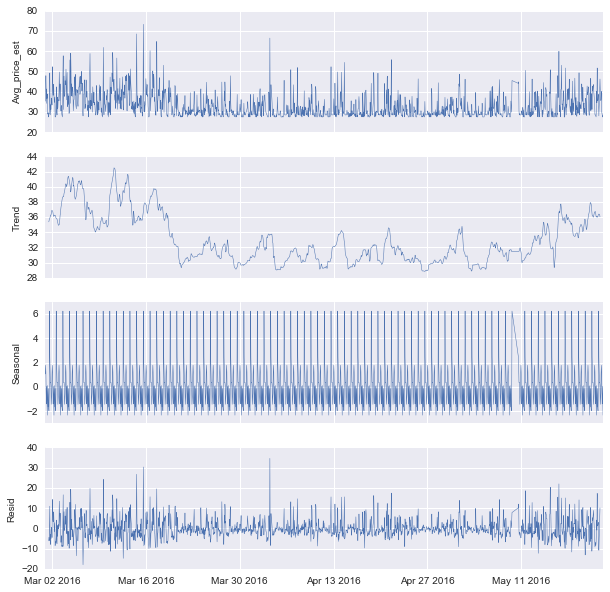

In [142]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(hr.dropna()['avg_price_est'].values, model='additive', freq=24)  
hr_decomp = hr.dropna().copy()
hr_decomp['trend'] = decomposition.trend
hr_decomp['seasonal'] = decomposition.seasonal
hr_decomp['resid'] = decomposition.resid
# print hr_decomp.head()
fig, axs = plt.subplots(4,1, figsize=(10,10), sharex=True)
columns = ['avg_price_est','trend','seasonal','resid']
for i, ax in enumerate(axs):
    ax.plot(hr_decomp.index, hr_decomp[columns[i]].values, lw=.5)
    ax.set_ylabel(columns[i].capitalize(), size=10)

In [151]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale

In [145]:
hr = pd.get_dummies(hr, columns=['dayofweek','hour'], drop_first=True)
hr.head()

,avg_price_est,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_1,hour_2,hour_3,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
record_time,,,,,,,,,,,,,,,,,,,,,
2016-03-01 00:00:00,35.289474,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-01 01:00:00,43.146552,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-01 02:00:00,47.929825,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-01 03:00:00,40.275862,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-01 04:00:00,34.175439,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
hr2 = hr.dropna().copy()
split = int(hr2.shape[0] * 0.5)
X, y = hr2[hr2.columns.tolist()[1:]], hr2['avg_price_est']
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

params = {
    'C' : [1,10,100],
    'kernel' : ['rbf','sigmoid'],
    'gamma' : [0.0, 0.1]
}

optimizer = GridSearchCV(SVR(), param_grid=params, verbose=True)
optimizer.fit(X_train, y_train)
best_params = optimizer.best_params_
model = optimizer.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.3s finished


Out of sample MSE: 23.3536808283
In sample MSE: 42.8278209717
Dummy MSE: 30.6794965983


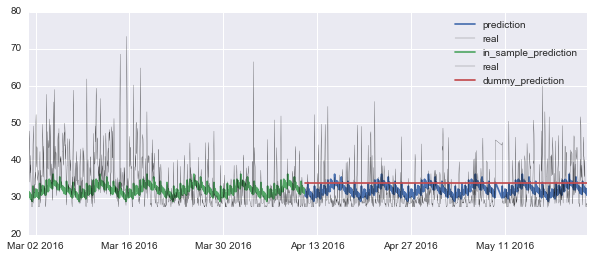

In [181]:
plt.figure(figsize=(10,4))
prediction = model.predict(X_test)
print("Out of sample MSE: {0}".format(mean_squared_error(y_test.values,prediction)))
plt.plot(X_test.index, prediction, label='prediction')
plt.plot(y_test.index, y_test, lw=0.2, color='k',label='real')
plt.legend()

in_sample_prediction = model.predict(X_train)
print("In sample MSE: {0}".format(metrics.mean_squared_error(y_train,in_sample_prediction)))
plt.plot(X_train.index, in_sample_prediction, label='in_sample_prediction')
plt.plot(y_train.index, y_train, lw=0.2, color='k',label='real',)
plt.legend()

from sklearn.dummy import DummyRegressor
r = DummyRegressor()
r.fit(X_train,y_train)
dummy_prediction = r.predict(X_test)
print("Dummy MSE: {0}".format(metrics.mean_squared_error(y_test,dummy_prediction)))
plt.plot(X_test.index, dummy_prediction, label='dummy_prediction')
plt.legend()

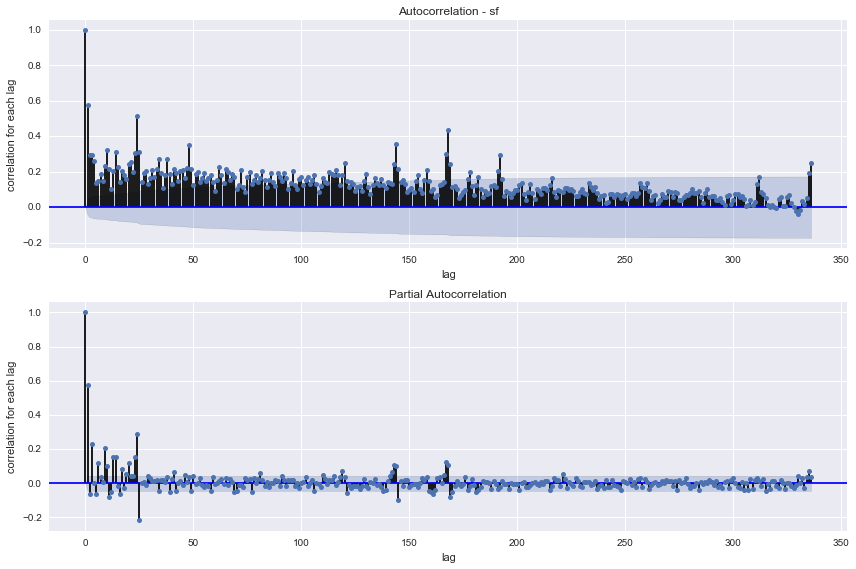

In [178]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data, lags, label):
    """
    Input: Amount of lag
    Output: Plot of ACF/PACF
    """
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=lags, ax=ax1)
    ax1.set_ylabel('correlation for each lag')
    ax1.set_xlabel('lag')
    ax1.set_title('Autocorrelation - {}'.format(label))
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=lags, ax=ax2)
    ax2.set_xlabel('lag')
    ax2.set_ylabel('correlation for each lag')
    plt.tight_layout()
plot_acf_pacf(hr2['avg_price_est'], lags=24*14, label='sf')

Lags with highest autocorrelation Int64Index([0, 1, 24], dtype='int64')


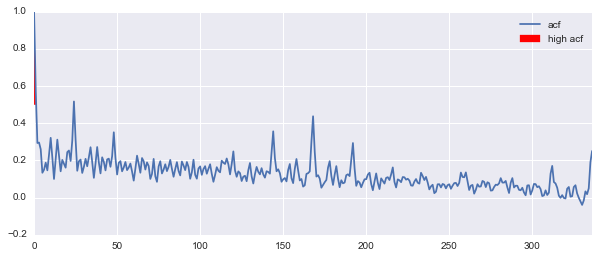

In [182]:
nlags=14*24
correlation_threshold = .5
acf = sm.tsa.acf(hr2['avg_price_est'], nlags=nlags)
acf = pd.Series(data=acf, index=np.arange(nlags+1), name='acf')
lags = acf[acf >= correlation_threshold].index
print("Lags with highest autocorrelation {l}".format(l=lags))

ax = acf.plot(figsize=(10,4))
ymin, ymax = ax.get_ylim()
high_acf = acf.index.map(lambda x: x in lags)
ax.fill_between(acf.index,correlation_threshold, acf,where=high_acf,alpha=1,color='r',label='high acf')
plt.legend()